# Classificador de Pose

.

Este _notebook_ é parte do trabalho [pixel sides](pixel-sides.ipynb). Ele descreve um experimento de criação de um
classificador de pose de imagens de personagens em _pixel art_ para estimar para que lado o personagem está virado:
de costas, esquerda, frente ou direita:






![center](docs/tiny-hero-sides.png)

O objetivo deste experimento foi de exercitar a criação de um classificador de rede neural convolucional (CNN)
para a pose do personagem.

Primeiramente, os dados são carregados (seção [Carregando o dataset](#Carregando-o-dataset)) e, em seguida,
é construída e treinada uma rede neural convolucional (seção [Classificador CNN](#Classificador-CNN)).

Além disso, a rede construída e treinada no _dataset_ TinyHero foi usada para prever as poses de novas imagens 
de personagens em _pixel art_ foram colhidas e os resultados estão na seção do 
[Experimento EXTRA: testar em outro dataset](#Experimento-EXTRA:-testar-em-outro-dataset).

In [66]:
# importação de pacotes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print("Versão do TensorFlow: ", tf.__version__)

import PIL
import imageio
from IPython import display

Versão do TensorFlow:  2.5.0


Configuração de variáveis do experimento:

In [67]:
SEED = 42
np.random.seed(SEED)

DATA_FOLDER = "tiny-hero"
DATASET_SIZE = 3648
BATCH_SIZE = 64 
IMAGE_SIZE = 64
CHANNELS = 4
EPOCHS = 10

## Carregando o _dataset_

O _dataset_ usado se chama [TinyHero](https://www.kaggle.com/calmness/retro-pixel-characters-generator/) e é composto por 3648 arquivos de imagem (64, 64, 4) divididos em 4 classes, cada uma representando uma direção para onde o personagem está virado.

Os dados rotulados foram divididos em treinamento e teste em proporção 80/20.

In [68]:
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_FOLDER,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE))

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_FOLDER,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE))

class_names = X_train.class_names

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, -1)
X_train = X_train.map(lambda x, y: (normalization_layer(x), y)).shuffle(DATASET_SIZE, seed=SEED)
X_validation = X_validation.map(lambda x, y: (normalization_layer(x), y))

Found 3648 files belonging to 4 classes.
Using 2919 files for training.
Found 3648 files belonging to 4 classes.
Using 729 files for validation.


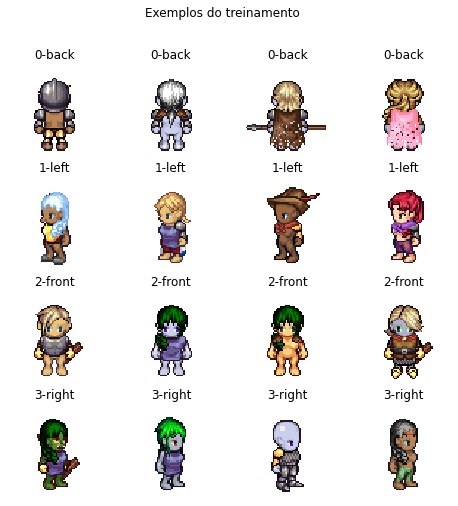

In [69]:
def denormalize_image(image):
    return (image + 1) / 2

def show_image(image):
    plt.imshow(image, interpolation="nearest")
    
def show_normalized_image(image):
    show_image(denormalize_image(image))

plt.figure(figsize=(8, 8))
plt.suptitle("Exemplos do treinamento")
for i in range(4):
    X_train_by_class = X_train.filter(lambda x, l: tf.math.equal(l[0], i))
    for j in range(4):
        for images, labels in X_train_by_class.take(1):
            ax = plt.subplot(4, 4, (i*4+j)+1)
            show_normalized_image(images[0])
            plt.title(class_names[labels[0]])
            plt.axis("off")

In [70]:
X_train = X_train.cache().shuffle(DATASET_SIZE, seed=SEED).prefetch(buffer_size=tf.data.AUTOTUNE)
X_validation = X_validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Classificador CNN

Após experimentação, foi gerado um classificador capaz de convergir para aproximadamente 100% de acurácia em apenas 10 épocas de treinamento.

![center](docs/pose-classifier-diagram.svg)

A arquitetura possui 2 sequências de convolução e _max pooling_, seguidas de duas camadas totalmente conectadas. A última tem ativação _softmax_
com 4 saídas e indica a confiança do modelo na classificação de cada exemplo quanto às 4 classes (costas, esquerda, frente, direita).

As duas primeiras camadas possuem 2 e 4 filtros de tamanho (3,3) e reduzem a dimensão da entrada pela metade
devido ao preenchimento na convolução e o filtro (2,2) do _max pooling_. Além disso, sua ativação usa
_rectified linear unit_.

O total de parâmetros treináveis é 24.850.

O otimizador usado foi o Adam com parâmetros:

- $alpha = 0.001$ (taxa de aprendizado)
- $beta_1 = 0.9$ (taxa de decaimento exponencial do primeiro momento)
- $beta_2 = 0.999$ (taxa de decaimento exponencial do segundo momento)


In [71]:
pose_classifier = keras.Sequential([
    layers.Conv2D(2, 3, padding="same", activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPool2D(),
    
    layers.Conv2D(4, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(24),
    layers.Dense(len(class_names), activation="softmax")
])

pose_classifier.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

pose_classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 2)         74        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 4)         76        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 4)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                24600     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

In [72]:
history = pose_classifier.fit(
  X_train,
  validation_data=X_validation,
  epochs=EPOCHS
)

Epoch 1/10
46/46 [==============================] - 2s 15ms/step - loss: 0.7619 - accuracy: 0.7729 - val_loss: 0.2247 - val_accuracy: 0.9698
Epoch 2/10
46/46 [==============================] - 0s 9ms/step - loss: 0.1087 - accuracy: 0.9839 - val_loss: 0.0423 - val_accuracy: 0.9904
Epoch 3/10
46/46 [==============================] - 0s 9ms/step - loss: 0.0453 - accuracy: 0.9901 - val_loss: 0.0247 - val_accuracy: 0.9959
Epoch 4/10
46/46 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 0.9973 - val_loss: 0.0129 - val_accuracy: 0.9973
Epoch 5/10
46/46 [==============================] - 0s 9ms/step - loss: 0.0118 - accuracy: 0.9986 - val_loss: 0.0128 - val_accuracy: 0.9973
Epoch 6/10
46/46 [==============================] - 0s 8ms/step - loss: 0.0087 - accuracy: 0.9990 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 7/10
46/46 [==============================] - 0s 9ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.0061 - val_accuracy: 0.9986
Epoch 8/10
46/46 [=

Após o treinamento, foram analisados a acurácia e o erro da rede tanto em treinamento quanto no conjunto de teste.

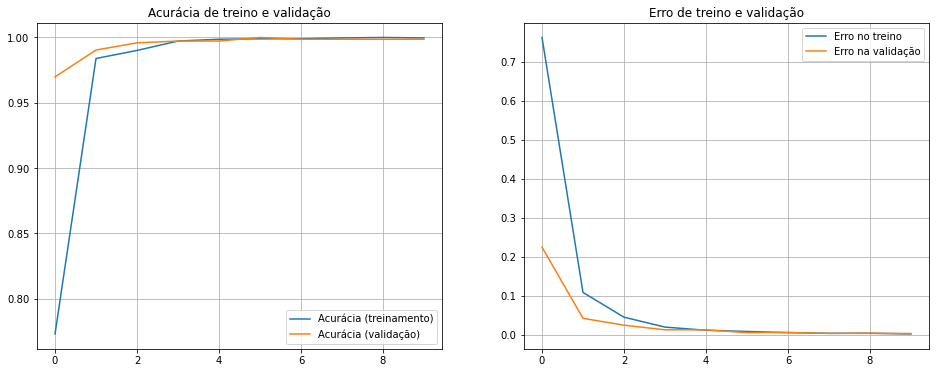

In [73]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Acurácia (treinamento)")
plt.plot(epochs_range, val_acc, label="Acurácia (validação)")
plt.legend(loc="lower right")
plt.grid()
plt.title("Acurácia de treino e validação")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Erro no treino")
plt.plot(epochs_range, val_loss, label="Erro na validação")
plt.legend(loc="upper right")
plt.title("Erro de treino e validação")
plt.grid()
plt.show()

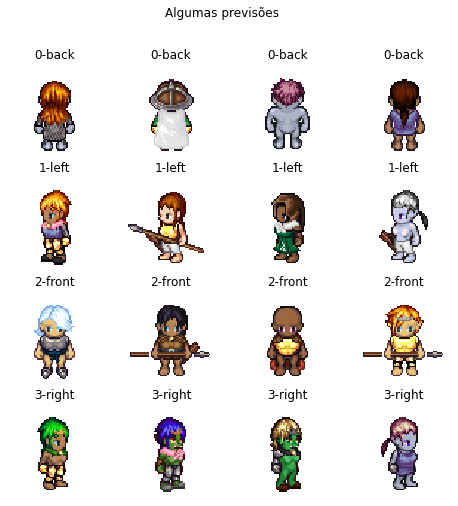

In [74]:
Y_predicted = np.argmax(pose_classifier.predict(X_validation), axis=1).astype(int).reshape(int(DATASET_SIZE*0.2), 1)
X_validation_unbatched = np.array(list(X_validation.unbatch().as_numpy_iterator()), dtype=object)
X_validation_unbatched = np.concatenate((X_validation_unbatched, Y_predicted), axis=1)

X_validation_by_class = dict()
for c, (image, y, y_hat) in enumerate(X_validation_unbatched):
    if y_hat not in X_validation_by_class:
        X_validation_by_class[y_hat] = []
    X_validation_by_class[y_hat].append((image, y, y_hat))

plt.figure(figsize=(8, 8))
plt.suptitle("Algumas previsões")
for i, class_name in enumerate(class_names):
    indices = np.arange(len(X_validation_by_class[i]), dtype="int")
    indices = np.random.choice(indices, size=4, replace=False)
    examples_from_current_class = np.array(X_validation_by_class[i], dtype=object)[indices]
    for j in range(4):
        ax = plt.subplot(4, 4, (i*4+j)+1)
        show_normalized_image(examples_from_current_class[j][0])
        plt.title(class_names[examples_from_current_class[j][2]])
        plt.axis("off")

### Experimento EXTRA: testar em outro _dataset_

O modelo treinado no _dataset_ TinyHero foi então aplicado a algumas imagens extraídas do programa RPG Maker 2000 
(vide [00-pick-images-from-rpgmaker.ipynb](00-pick-images-from-rpgmaker.ipynb)). São apenas 96 imagens e elas
eram originalmente de (32, 24) mas foram aumentadas/preenchidas respeitando a razão de aspecto para (64, 64).



**Ideias pra aumentar aqui**:
1. Mostrar as que foram erradas e fazer análise
2. Testar com outras imagens pixel art
3. Testar com fotos ou imagens de alta resolução (reduzidas para 64x64)

In [76]:
DATA_FOLDER_EXTRA = "rpg-maker"
DATASET_SIZE_EXTRA = 96

# carrega e prepara o dataset
X_validation_extra = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_FOLDER_EXTRA,
    color_mode="rgba",
    seed=SEED,
    batch_size=DATASET_SIZE_EXTRA,
    image_size=(IMAGE_SIZE, IMAGE_SIZE))

X_validation_extra = X_validation_extra.map(lambda x, y: (normalization_layer(x), y))
X_validation_extra_labels = X_validation_extra.map(lambda x, y: y)
X_validation_extra = X_validation_extra.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
_, X_validation_extra_labels = next(iter(X_validation_extra))

Found 96 files belonging to 4 classes.


Com o _dataset_ carregado e preparado, o modelo foi usado novamente para predizer as classes de direção das novas imagens.
Os resultados são exibidos em uma matriz de confusão e com algumas amostras das previsões.

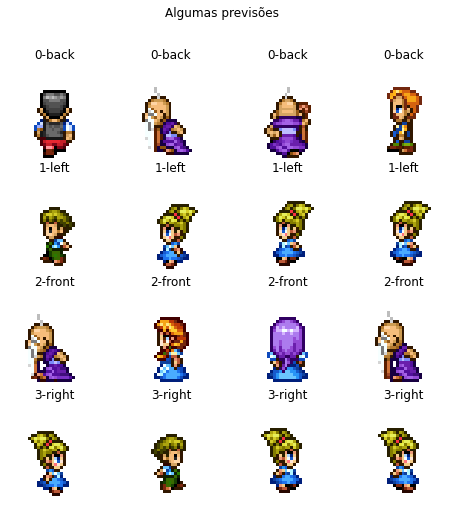

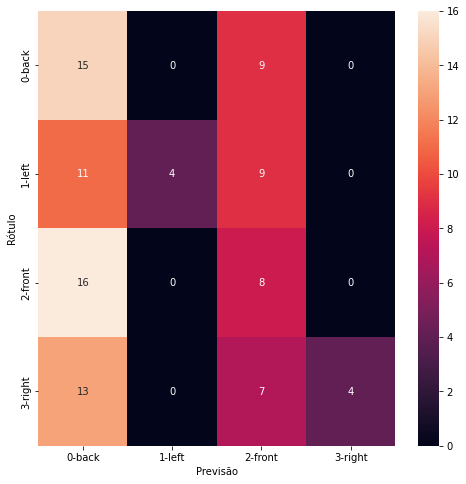

In [79]:
# faz as previsões das poses das imagens
Y_predicted_extra = np.argmax(pose_classifier.predict(X_validation_extra), axis=1).astype(int).reshape(DATASET_SIZE_EXTRA, 1)
X_validation_unbatched_extra = np.array(list(X_validation_extra.unbatch().as_numpy_iterator()), dtype=object)
X_validation_unbatched_extra = np.concatenate((X_validation_unbatched_extra, Y_predicted_extra), axis=1)

X_validation_by_class_extra = dict()
for c, (image, y, y_hat) in enumerate(X_validation_unbatched_extra):
    if y_hat not in X_validation_by_class_extra:
        X_validation_by_class_extra[y_hat] = []
    X_validation_by_class_extra[y_hat].append((image, y, y_hat))

confusion_mtx = tf.math.confusion_matrix(X_validation_extra_labels, tf.reshape(Y_predicted_extra, DATASET_SIZE_EXTRA), 4)

# exibe os resultados
plt.figure(figsize=(8, 8))
plt.suptitle("Algumas previsões")
for i, class_name in enumerate(class_names):
    indices = np.arange(len(X_validation_by_class_extra[i]), dtype="int")
    indices = np.random.choice(indices, size=4, replace=False)
    examples_from_current_class = np.array(X_validation_by_class_extra[i], dtype=object)[indices]
    for j in range(4):
        ax = plt.subplot(4, 4, (i*4+j)+1)
        show_normalized_image(examples_from_current_class[j][0])
        plt.title(class_names[examples_from_current_class[j][2]])
        plt.axis("off")
plt.show()
        
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True)
plt.xlabel('Previsão')
plt.ylabel('Rótulo')
plt.show()
